# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [1]:
!pip install catboost -q

In [2]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error

In [3]:
!ls /kaggle/input/competative-data-science-course-by-data-feeling/

car_test.csv  car_train.csv  driver_info.csv  fix_info.csv  rides_info.csv


## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке 
- `main_city` - город пребывания машины. (Москва или Питер)
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


car_id            model  car_type fuel_type  car_rating  \
1251  A18130070W    Smart ForFour   economy    petrol        3.52   
413   p33048720U  Renault Sandero  standart    petrol        1.32   
2104  f21340662W   Renault Kaptur  standart    petrol        3.20   
855   i-1445700R  Hyundai Solaris   economy    petrol        4.02   
1978  v-2144197C     Kia Sportage  standart    petrol        5.20   

      year_to_start  riders  year_to_work  target_reg     target_class  
1251           2017  109933          2021     3953.61  engine_ignition  
413            2015   83853          2021     3943.20      engine_fuel  
2104           2015   73265          2018    10051.02      another_bug  
855            2015   71710          2020     2198.22      another_bug  
1978           2012   20310          2016     3428.18     engine_check

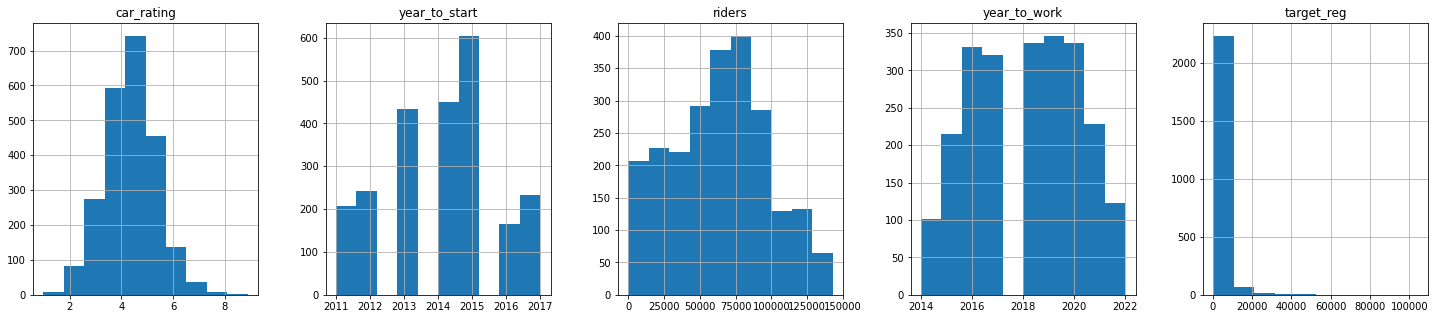

In [4]:
path = '../input/competative-data-science-course-by-data-feeling/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(25, 5), layout = (-1, 5))
train.sample(5)

In [5]:
path = '../input/competative-data-science-course-by-data-feeling/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(5)

(1913, 8)


car_id           model  car_type fuel_type  car_rating  \
1491  C-7657933N     Smart Coupe   economy    petrol        3.94   
1003  E41968356d   Tesla Model 3   premium   electro        4.40   
253   A41423630m       VW Tiguan   economy    petrol        4.56   
626   B-1760099A  Renault Kaptur  standart    petrol        4.36   
1510  N-2173692X       VW Tiguan   economy    petrol        4.54   

      year_to_start  riders  year_to_work  
1491           2016  102335          2018  
1003           2015   71600          2020  
253            2013   36218          2020  
626            2015   95768          2020  
1510           2017  120335          2018

## Классифицируем признаки на типы

In [6]:
features2drop = ['car_id'] 
targets = ['target_class', 'target_reg']  
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Обучаем Catboost и делаем прогноз на тест

In [7]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 100)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.263488
0:	learn: 2.1785390	test: 2.1943955	best: 2.1943955 (0)	total: 93.2ms	remaining: 9.23s
99:	learn: 1.4720249	test: 2.3118861	best: 2.1851470 (5)	total: 2.2s	remaining: 0us

bestTest = 2.185146963
bestIteration = 5

Shrink model to first 6 iterations.

 Accuracy: 0.11324786324786325


In [8]:
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения в машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [9]:
path = '../input/competative-data-science-course-by-data-feeling/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
574985  y21951136D  o21208881t     P1N  2020-02-17    5.08             27   
57553   o10674666M  D88984934M     F1z  2020-03-11    2.80             41   
555015  y80328134L  n-2171056h     g1P  2020-03-09    5.17             51   
331240  b15037804V  X18004949I     p1h  2020-03-03    5.06             37   
145345  V12033758g  K-7253573V     N1v  2020-01-30    3.60          32449   

        ride_cost  speed_avg  speed_max  stop_times      distance  refueling  \
574985        535         39  66.000000           1  7.581959e+02          0   
57553         568         42  69.000000           2  8.146059e+02          0   
555015        403         90  94.087452           0  4.657219e+03          0   
331240        439         26  35.000000           1  8.079192e+02          0   
145345     519178         40  59.079370           0  1.323174e+06          0   

        user_ride_quality  deviation_normal  
574985         -11.600308           -14.715  
57553          -20.264456             3.673  
555015           7.677557            11.273  
331240          -1.323782            34.015  
145345         -15.013255            32.766

In [10]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

car_id  mean_rating  distance_sum  rating_min   speed_max  \
0  A-1049127W    49.459770  1.125753e+07         0.1  179.729652   
1  A-1079539w    49.591954  1.912765e+07         0.1  184.505566   

   user_ride_quality_median  deviation_normal_count  user_uniq  
0                 -0.288229                     174        172  
1                  2.508746                     174        173

In [11]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

In [12]:
train.sample(2)

car_id       model car_type fuel_type  car_rating  year_to_start  \
586   A-4064758I  VW Polo VI  economy    petrol        4.76           2014   
2311  e-1590992X   Kia Rio X  economy    petrol        6.26           2012   

      riders  year_to_work  target_reg target_class  mean_rating  \
586    69687          2015      591.68  wheel_shake    44.431034   
2311   27706          2017     1663.59  electro_bug    49.902299   

      distance_sum  rating_min   speed_max  user_ride_quality_median  \
586   1.283349e+07         0.1  144.680070                 15.410572   
2311  1.896630e+07         0.0  176.993796                 -3.167937   

      deviation_normal_count  user_uniq  
586                      174        169  
2311                     174        172

In [13]:
train.to_csv('quickstart_train.csv', index=False)

# Снова обновляем типы фичей

In [14]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Обучаем Catboost на новых данных и делаем новый прогноз

In [15]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 150)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.22568
0:	learn: 1.6152296	test: 1.6272818	best: 1.6272818 (0)	total: 32.9ms	remaining: 4.91s
149:	learn: 0.2770299	test: 0.7043549	best: 0.6894705 (66)	total: 4.02s	remaining: 0us

bestTest = 0.6894705365
bestIteration = 66

Shrink model to first 67 iterations.

 Accuracy: 0.7136752136752137


In [16]:
fi = clf.get_feature_importance(prettified=True)
fi

Feature Id  Importances
0                  speed_max    37.614472
1                mean_rating    29.077088
2                 rating_min    13.849362
3                   car_type     3.855765
4                  user_uniq     3.587689
5                      model     3.178964
6   user_ride_quality_median     2.068787
7                 car_rating     2.057513
8               distance_sum     1.788548
9                     riders     1.311904
10              year_to_work     1.056091
11             year_to_start     0.553818
12                 fuel_type     0.000000
13    deviation_normal_count     0.000000

In [17]:
test['target_class'] = clf.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


# Что дальше?

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`